In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#Print total number of seqs before and after filtering (for seqs longer than 1000nt)
full_cov_data = '../data/human_cov_full.fasta'
full_cov_filtered = '../results/filtered_cov_full.fasta'

cov_total = 0
cov_seq_lengths = []
cov_filtered = 0
cov_filtered_lengths = []
with open(full_cov_data, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        cov_total+=1
        cov_seq_lengths.append(len(record.seq))
with open(full_cov_filtered, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        cov_filtered+=1
        cov_filtered_lengths.append(len(record.seq))

print(f'total seqs: {cov_total}\nafter filtering: {cov_filtered}')

total seqs: 4606
after filtering: 3886


In [15]:
#Find how many total sequences for each virus
#And then how many of these sequences align to each gene
viruses = ['oc43', '229e', 'nl63', 'hku1']
full_virus_totals = {}
virus_filtered_totals = {}
for virus in viruses:
    virus_full = 0
    virus_filtered_total = 0
    virus_filtered = '../'+str(virus)+'/results/filtered_'+str(virus)+'_full.fasta'
    with open(virus_filtered, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            virus_filtered_total+=1
            if len(record.seq) > 25000:
                virus_full +=1
    full_virus_totals[virus] = virus_full
    virus_filtered_totals[virus] = virus_filtered_total

for virus in viruses:
    print(f'{virus} seqs after filtering: {virus_filtered_totals[virus]} \nfull length {virus} seqs: {full_virus_totals[virus]}')

oc43 seqs after filtering: 374 
full length oc43 seqs: 69
229e seqs after filtering: 167 
full length 229e seqs: 27
nl63 seqs after filtering: 345 
full length nl63 seqs: 64
hku1 seqs after filtering: 102 
full length hku1 seqs: 27


In [4]:
def get_virus_genes(virus):
    if virus == 'nl63':
        genes_dict = {'replicase1ab':"replicase polyprotein 1ab", 'spike':"spike protein", 'protein3':"protein 3", 
                      'envelope':"envelope protein", 'membrane':"membrane protein", 'nucleocapsid':"nucleocapsid protein", 
                      's1':'spike_subdomain1', 's2':'spike_subdomain2'}
    elif virus == '229e':
        genes_dict = {'replicase1ab':"replicase polyprotein 1ab", 'replicase1a': "replicase polyprotein 1a", 'spike':"surface glycoprotein", 
                      'protein4a':"4a protein", 'protein4b':"4b protein",
                      'envelope':"envelope protein", 'membrane':"membrane protein", 'nucleocapsid':"nucleocapsid protein", 
                      's1':'spike_subdomain1', 's2':'spike_subdomain2'}
    elif virus == 'hku1':
        genes_dict = {'replicase1ab':"orf1ab polyprotein", 'he':"hemagglutinin-esterase glycoprotein", 
                      'spike':"spike glycoprotein", 'nonstructural4':"non-structural protein",
                      'envelope':"small membrane protein", 'membrane':"membrane glycoprotein", 
                      'nucleocapsid':"nucleocapsid phosphoprotein", 'nucleocapsid2':"nucleocapsid phosphoprotein 2", 
                      's1':'spike_subdomain1', 's2':'spike_subdomain2'}
    elif virus == 'oc43':
        genes_dict = {'replicase1ab':"replicase polyprotein", 'nonstructural2a':"NS2a protein",
                      'he':"HE protein", 'spike':"S protein", 'nonstructural2':"NS2 protein",
                      'envelope':"NS3 protein", 'membrane':"M protein", 
                      'nucleocapsid':"N protein", 'n2protein':"N2 protein", 
                      's1':'spike_subdomain1', 's2':'spike_subdomain2'}
    return genes_dict

In [32]:
def virus_seq_coverage(virus):
    strain_counts = {}
    
    full_datafile = '../'+str(virus)+'/data/'+str(virus)+'_full.fasta'
    with open(full_datafile, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            strain_counts[record.id.split('|')[0]] = 0
    
    
    gene_list = get_virus_genes(virus).keys()
    
    virus_gene_coverage = {}
    virus_year_coverage = {}
    for gene in gene_list:
        if gene!= 's1' and gene!= 's2':
            gene_total = 0
            min_year = 2020
            max_year = 0
            gene_seq_file = '../'+str(virus)+'/data/'+str(virus)+'_'+str(gene)+'.fasta'
            with open(gene_seq_file, "r") as handle:
                for record in SeqIO.parse(handle, "fasta"):
                    strain_counts[record.id.split('|')[0]]+=1
                    gene_total+=1
                    if record.id.split('|')[3][0:4] != 'NA':
                        if int(record.id.split('|')[3][0:4]) < min_year:
                            min_year = int(record.id.split('|')[3][0:4])
                        elif int(record.id.split('|')[3][0:4]) > max_year:
                            max_year = int(record.id.split('|')[3][0:4])
            virus_gene_coverage[gene] = gene_total
            virus_year_coverage[gene] = str(min_year) + '-' + str(max_year)
    
    strain_coverage = pd.DataFrame(list(strain_counts.items()), index=[x for x in range(len(strain_counts))], 
                                   columns=['strain', 'gene_coverage'])
#     plt.hist(strain_coverage['gene_coverage'], bins = [x for x in range(0,max(strain_coverage['gene_coverage']))])
    
    gene_coverage = pd.DataFrame(list(virus_gene_coverage.items()), index=[x for x in range(len(virus_gene_coverage))], 
                                   columns=['gene', 'gene_coverage'])
    
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax = sns.barplot(x='gene', y='gene_coverage', color='salmon', data=gene_coverage)
    plt.ylim(0,350)
    plt.title(str(virus), size=20)
    plt.xlabel('gene', size=16)
    plt.ylabel('sequences covering each gene', size=16)
    
    no_coverage = len(strain_coverage[strain_coverage['gene_coverage']==0])
    at_least_one_gene = len(strain_coverage[strain_coverage['gene_coverage']>=1])
    print(f'{virus} sequences that dont cover any genes: {no_coverage}\nsequences that cover at least one gene: {at_least_one_gene}')
    

oc43 sequences that dont cover any genes: 129
sequences that cover at least one gene: 322
229e sequences that dont cover any genes: 188
sequences that cover at least one gene: 113
nl63 sequences that dont cover any genes: 357
sequences that cover at least one gene: 247
hku1 sequences that dont cover any genes: 299
sequences that cover at least one gene: 67


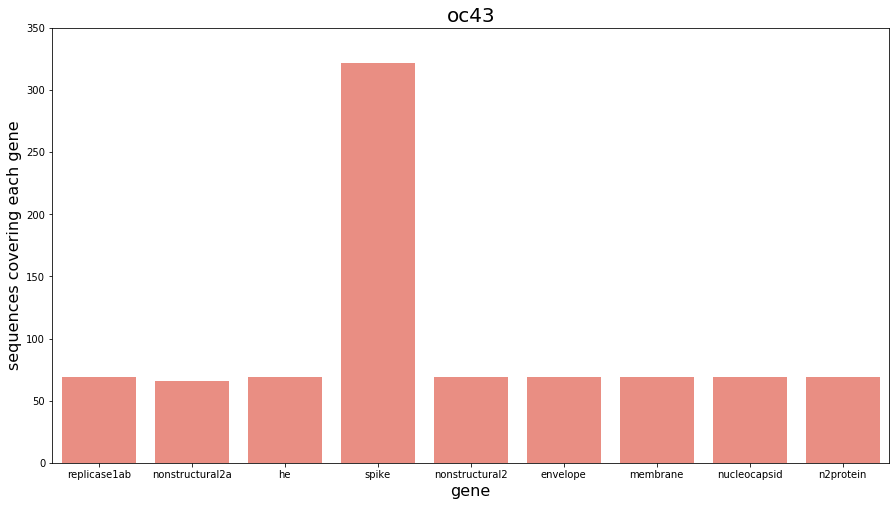

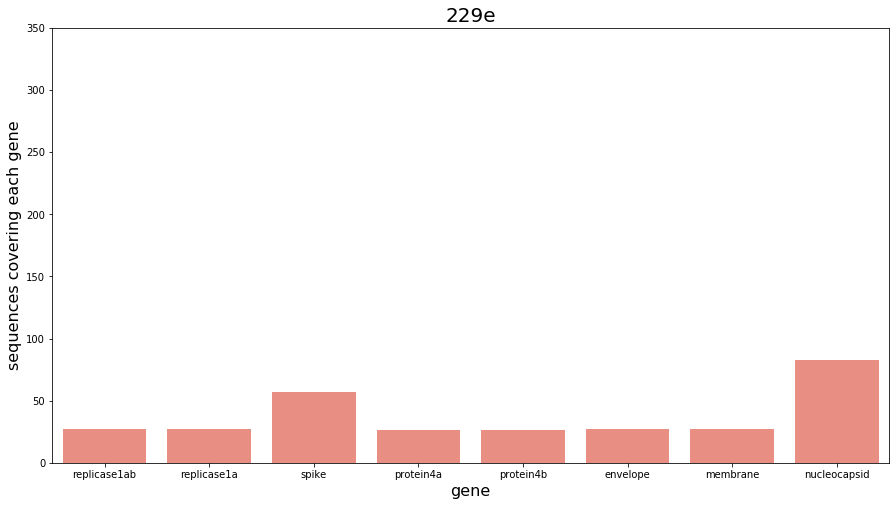

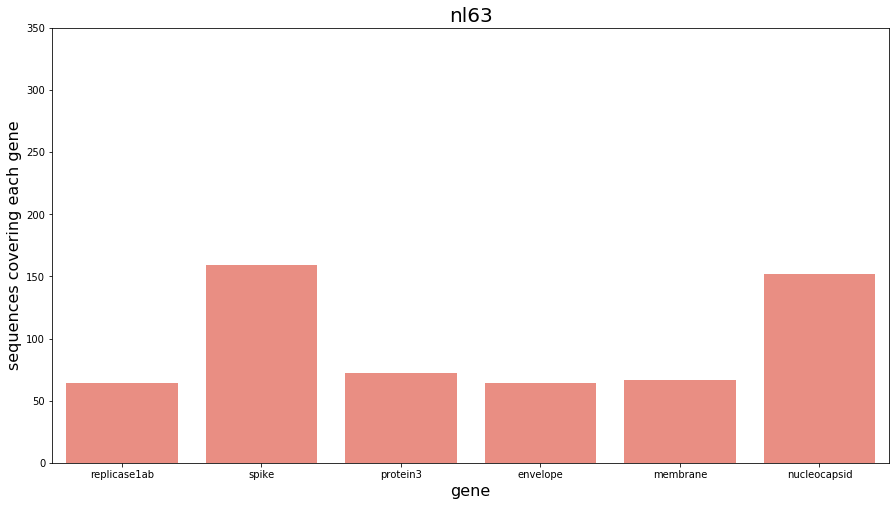

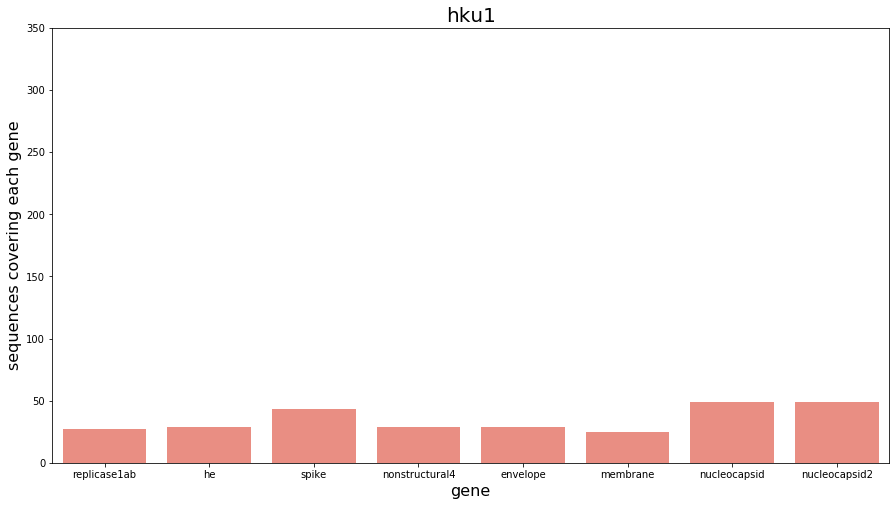

In [33]:
viruses = ['oc43', '229e', 'nl63', 'hku1']
for virus in viruses:
    virus_seq_coverage(virus)